In [8]:
import curr_adventure as cad 
import jax.numpy as jnp
from jax import random as jrandom
from jax import jit, partial, grad, jacfwd
import numpy as np


from curr_adventure.derivative_estimation.one_E_zero import SD_1E0
from curr_adventure.derivative_estimation.grid_generation import generate_ellipse


from utils import run_tests, mse_loss

from scipy.stats import linregress
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

from jax.config import config
config.update("jax_enable_x64", True)

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dim = 10
M = 100

Sigma_half = np.random.normal(size=(dim, dim))
Sigma_half = np.eye(dim) * 0.1

Sigma = Sigma_half.dot(Sigma_half.T)


W = np.random.normal(size=(dim, M))
b = np.ones(M) 

B = cad.Barriers.LogPolytopeBarrier(W.T, b)

x_1 = np.ones(dim) / np.linalg.norm(np.ones(dim))

num_samples = 10

hs = np.random.normal(size=(dim, num_samples))
hs /= np.linalg.norm(hs, axis=0)

In [10]:
numers = hs.T.dot(W) # num_samples x M. Every column are all the innerproducts of one w_i with all hs. 

true_res = []
upper_bound_res = []

for alpha in np.linspace(0, 0.35, 10):
    dists, signs = B._get_dists(alpha * x_1)
    
    if any(signs == 1):
        print(alpha)
        break
        
    denoms = 1./dists 
    
    true_res.append([np.abs(np.sum((numer * denoms)**3)) for numer in numers])
    upper_bound_res.append([np.sum((numer * denoms)**2)**(3./2) for numer in numers])
        
    
    
true_res = np.array(true_res)
upper_bound_res = np.array(upper_bound_res)
    

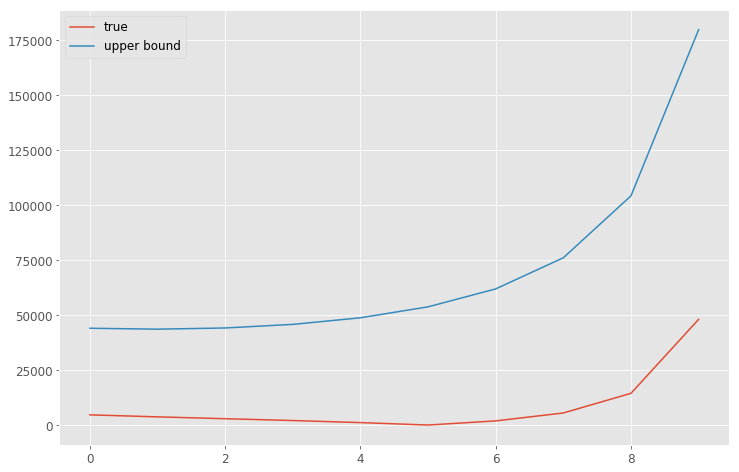

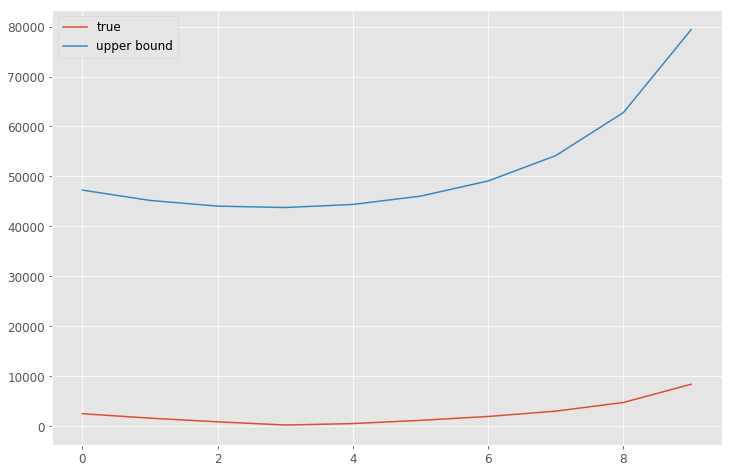

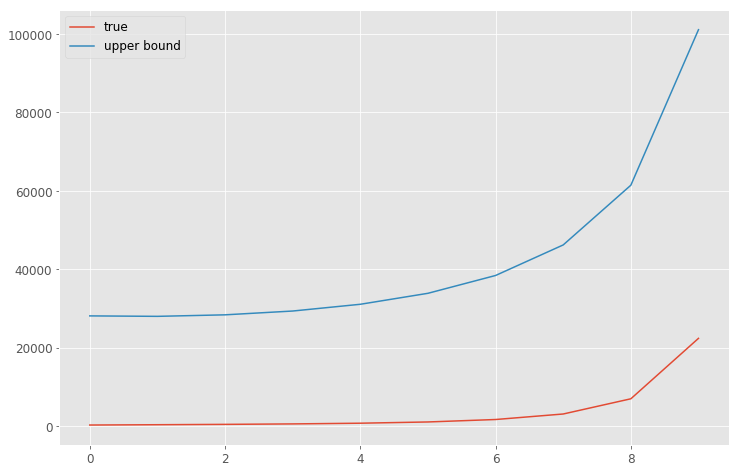

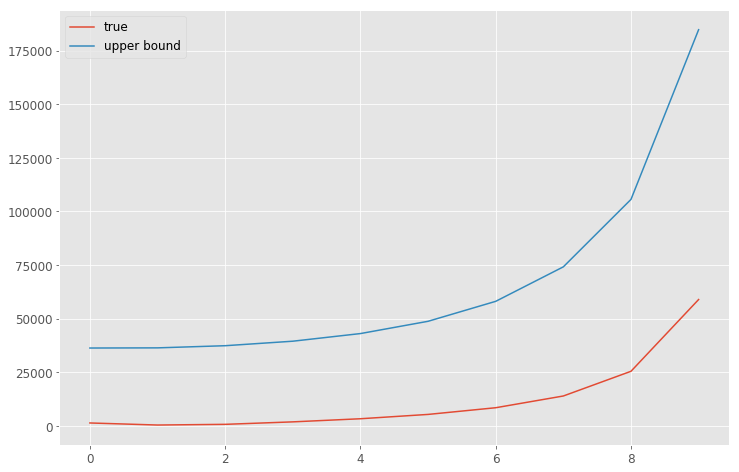

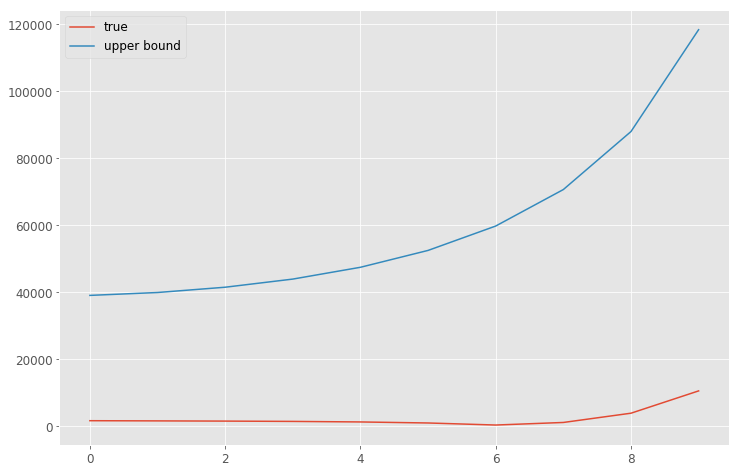

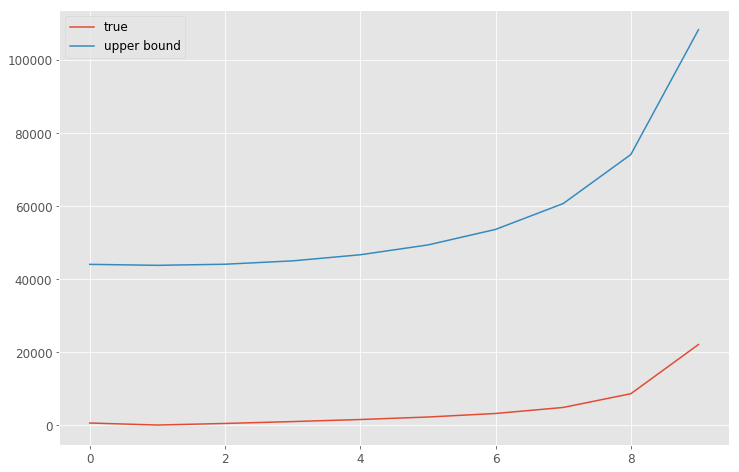

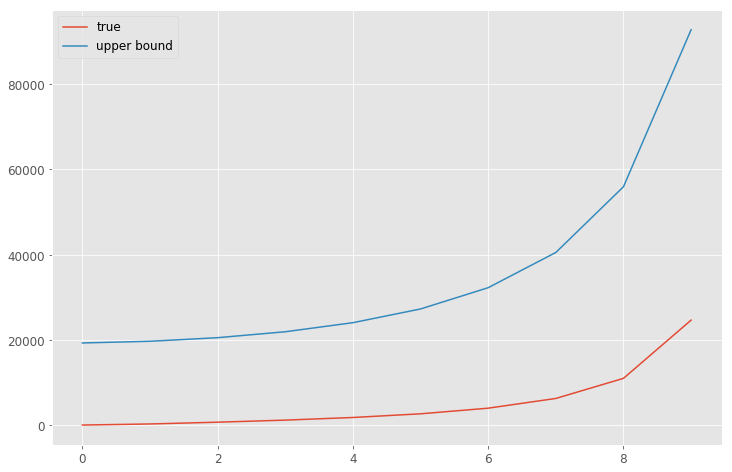

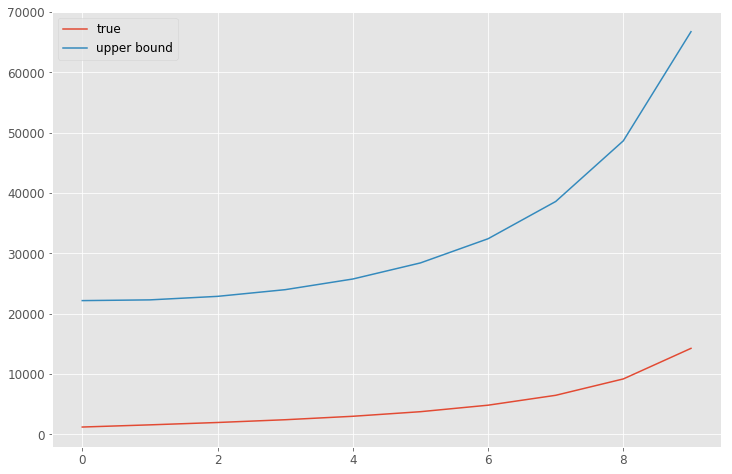

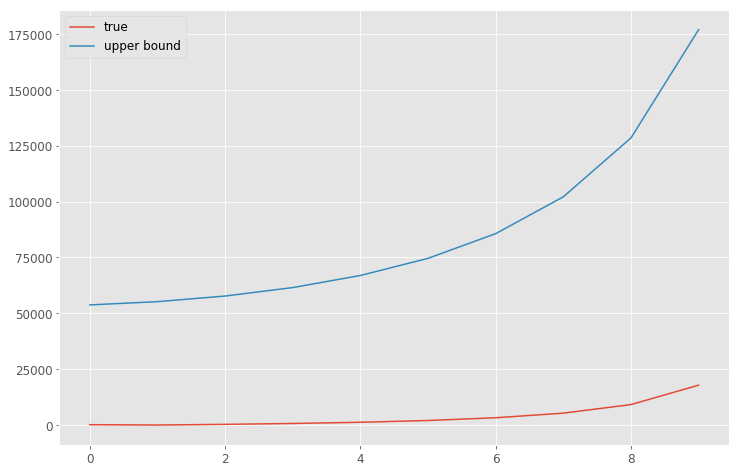

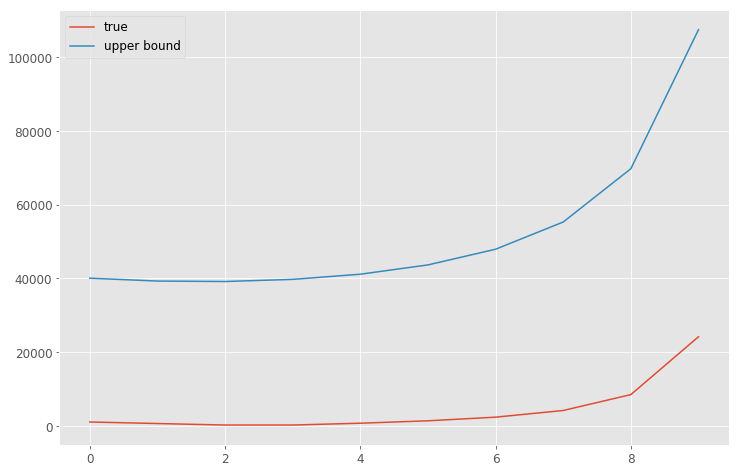

In [11]:
for i in range(num_samples):
    plt.plot(true_res[:, i], label="true")
    plt.plot(upper_bound_res[:, i], label="upper bound")
    plt.legend()
    plt.show()

Essentially, we would like to solve the following minimization problem 
\begin{align}
    \min_{X \in \mathbb{R}^{d \times N}} \quad & \Vert (SS^T)^{-1} \sum_{i = 1}^N D^3 f(x_0).(x_i - x_0)^{\otimes 3}(x_i - x_0)\Vert_2^2 \\
    &+ \sum_{i = 1}^N \sigma(x_i)^2 \Vert (SS^T)^{-1} (x_i - x_0)\Vert_2^2 \\
    \text{s.t.} \quad &  rank(X) = d. \\
\end{align}

This would not yet satisfy the symmetry assumption of $X$ in order to get rid of the second order error. However, we could just take $X' = X^* \cup -X^*$ as the new set, with $X^*$ being the solution to the optimization problem. 

The hope is then that the optimization problem 

\begin{align}
    \min_{X \in \mathbb{R}^{d \times N}} \quad & \Vert (SS^T)^{-1} \sum_{i = 1}^N 2 \Big(D^2 f(x_0).(x_i - x_0)^{\otimes 2}\Big)^{3/2}(x_i - x_0)\Vert_2^2 \\
    &+ \sum_{i = 1}^N \sigma(x_i)^2 \Vert (SS^T)^{-1} (x_i - x_0)\Vert_2^2 \\
    \text{s.t.} \quad &  rank(X) = d
\end{align}
has a solution $\tilde{X}^*$ which is close to the true solution $X^*$. 

In [244]:


class thirdOrderOpt:
    
    def __init__(self, D_three, sigma):
        self.D_three = D_three
        self.sigma = sigma
        
    def f(self, X, x_0):    
        """X.shape = (d, N)"""
        S = X - x_0.reshape(-1, 1) 
        DS = self.D_three(S)
        SDS = S.dot(DS)
        Sig = self.sigma(X)**2 
        
        SS_inv = jnp.linalg.inv(S.dot(S.T))
        
        first_term = jnp.linalg.norm(SS_inv.dot(SDS))**2
        second_term = (jnp.linalg.norm(SS_inv.dot(S), axis=0)**2).dot(Sig)
        
        return first_term #+ second_term
    
    
class secondOrderOpt:
    
    def __init__(self, D_two, sigma):
        self.D_two = D_two
        self.sigma = sigma
        
    def f(self, X, x_0):    
        """X.shape = (d, N)"""
        S = X - x_0.reshape(-1, 1) 
        DS = self.D_two(S)**(3./2)
        SxDS = S * DS
        Sig = self.sigma(X)**2 
        
        SS_inv = jnp.linalg.inv(S.dot(S.T))
        
        A = S.T.dot(SS_inv.dot(SS_inv.dot(S)))
        A = jnp.abs(A)
        
        first_term = 4*DS.T.dot(A.dot(DS))
        second_term = (jnp.linalg.norm(SS_inv.dot(S), axis=0)**2).dot(Sig)

        return first_term #+ second_term
        
        
def three_linear(W, b, x_0):
    
    
    B = cad.Barriers.LogPolytopeBarrier(W.T, b)
    
    dists, signs = B._get_dists(x_0) 
    denoms = 1./dists 
    
    def helper(hs):
        numers = hs.T.dot(W)
        return jnp.array([np.sum((numer * denoms)**3) for numer in numers])

        
    return helper
    
     
        
def two_linear(W, b, x_0):
    
    
    B = cad.Barriers.LogPolytopeBarrier(W.T, b)
    
    dists, signs = B._get_dists(x_0) 
    denoms = 1./dists 

    def helper(hs):
        numers = hs.T.dot(W)
        return jnp.array([np.sum((numer * denoms)**2) for numer in numers])

        
    return helper
        
        

In [252]:
dim = 10
M = 100

Sigma_half = np.random.normal(size=(dim, dim))
# Sigma_half = np.eye(dim) * 0.1

Sigma = Sigma_half.dot(Sigma_half.T)


W = np.random.normal(size=(dim, M))
b = np.ones(M) 

B = cad.Barriers.LogPolytopeBarrier(W.T, b)


num_samples = 15




In [279]:
# numers = hs.T.dot(W) # num_samples x M. Every column are all the innerproducts of one w_i with all hs. 

true_res = []
upper_bound_res = []

x_1 = np.ones(dim) / np.linalg.norm(np.ones(dim))

jrandom_key = jrandom.PRNGKey(0)


for alpha in np.linspace(0, 0.3, 100):
#     dists, signs = B._get_dists(alpha * x_1)
    
    x_0 = 0.3 * x_1
    
#     if any(signs == 1):
#         print(alpha)
#         break

    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    Sigma_half = np.random.normal(size=(dim, dim))

    hs = jrandom.normal(subkey, shape=(dim, num_samples))
    hs = Sigma_half.dot(hs)
    # hs /= np.linalg.norm(hs, axis=0)
    hs *= 0.2
        
    SO = secondOrderOpt(two_linear(W, b, x_0), lambda X: jnp.ones(num_samples) * 0.1)

    TO = thirdOrderOpt(three_linear(W, b, x_0), lambda X: jnp.ones(num_samples) * 0.1)

    true_res.append(TO.f(hs + x_0.reshape(-1, 1), x_0))
    upper_bound_res.append(SO.f(hs + x_0.reshape(-1, 1), x_0))
        
    
    
true_res = np.array(true_res)
upper_bound_res = np.array(upper_bound_res)
    

W0111 13:43:10.007737 4703088128 legend.py:1285] No handles with labels found to put in legend.


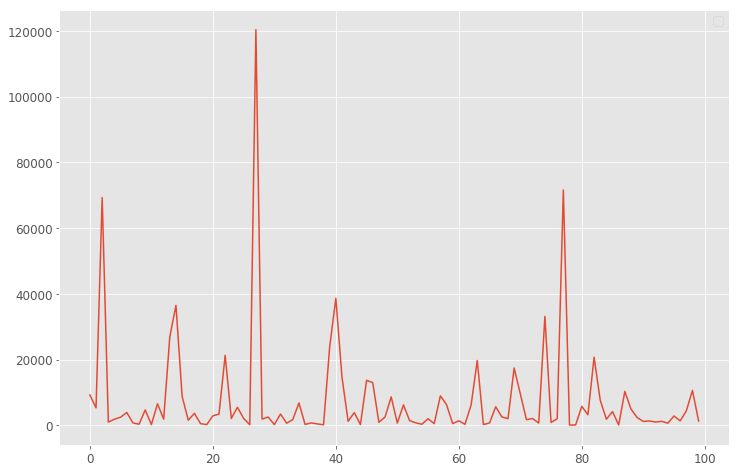

In [280]:
# plt.plot(true_res, label="True")
# plt.plot(upper_bound_res, label="upper")
plt.plot((upper_bound_res - true_res)/true_res)
plt.legend()
plt.show()


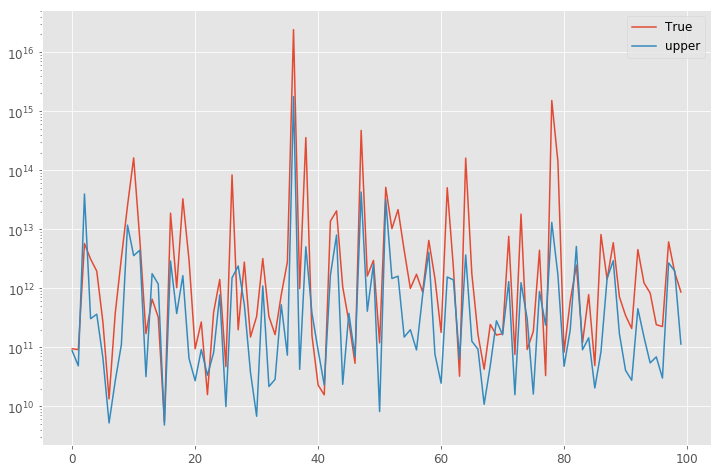

In [281]:
plt.plot(true_res, label="True")
plt.plot(upper_bound_res/1e4, label="upper")
# plt.plot((upper_bound_res - true_res)/true_res)
plt.legend()
plt.yscale("log")
plt.show()

